In [8]:
# Data for TSP and VRP, run first!!
import math, pulp
import matplotlib.pyplot as plt
from itertools import product
import pulp

nodes = {
    1: {'coords': (0, 0), 'demand': 0},
    2: {'coords': (3, 8), 'demand': 8},
    3: {'coords': (-6, 1), 'demand': 6},
    4: {'coords': (-1, 0), 'demand': 4},
    5: {'coords': (2, 4), 'demand': 4},
    6: {'coords': (-10, 10), 'demand': 1},
    7: {'coords': (-2, -1), 'demand': 3},
    8: {'coords': (5, -3), 'demand': 6},
    9: {'coords': (3, -1), 'demand': 4},
    10: {'coords': (9, 6), 'demand': 2},
    11: {'coords': (-5, -3), 'demand': 4},
    12: {'coords': (-2, -8), 'demand': 4},
    13: {'coords': (4, -9), 'demand': 4},
    14: {'coords': (4, -4), 'demand': 1},
    15: {'coords': (10, -7), 'demand': 9},
    16: {'coords': (9, -1), 'demand': 2},
    17: {'coords': (6, 8), 'demand': 1},
    18: {'coords': (-8, 0), 'demand': 3},
    19: {'coords': (4, 3), 'demand': 5},
    20: {'coords': (-3, -6), 'demand': 4}
}
vCap = 16 # capacity of vehicle, used for VRP
vNum = 5  # number of vehicle, used for VRP

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

distances = {}
for i, j in product(nodes, repeat=2):
    if i != j:
        distances[(i, j)] = euclidean_distance(nodes[i]['coords'], nodes[j]['coords'])


routes = {
    1: {'Route 1': []},
    2: {'Route 2': []},
    3: {'Route 3': []},
    4: {'Route 4': []},
    5: {'Route 5': []}
}


In [3]:
time_limit = 60*5 # Time Limit in seconds for pulp solver

Vehicle travels:
 from 1 to 5; flow = 15.0
 from 1 to 6; flow = 14.0
 from 1 to 7; flow = 15.0
 from 1 to 9; flow = 16.0
 from 1 to 16; flow = 16.0
 from 2 to 17; flow = 3.0
 from 3 to 4; flow = 4.0
 from 4 to 1; flow = 0.0
 from 5 to 2; flow = 11.0
 from 6 to 18; flow = 13.0
 from 7 to 11; flow = 12.0
 from 8 to 19; flow = 6.0
 from 9 to 8; flow = 12.0
 from 10 to 1; flow = 0.0
 from 11 to 20; flow = 8.0
 from 12 to 1; flow = 0.0
 from 13 to 14; flow = 1.0
 from 14 to 1; flow = 0.0
 from 15 to 13; flow = 5.0
 from 16 to 15; flow = 14.0
 from 17 to 10; flow = 2.0
 from 18 to 3; flow = 10.0
 from 19 to 1; flow = 1.0
 from 20 to 12; flow = 4.0
Total Distance Traveled (Objective Value): 127.81518313512275


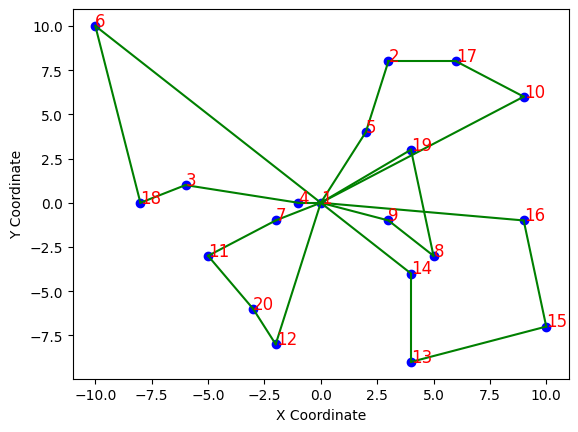

In [9]:
# Problem initialization
drp = pulp.LpProblem("Vehicle_Routing_Problem", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("x", [(i, j) for i in nodes for j in nodes if i != j], cat='Binary')  # Route selection
y = pulp.LpVariable.dicts("y", [(i, j) for i in nodes for j in nodes if i != j], lowBound=0, upBound=vCap, cat='Continuous')  # Load

# Objective function
drp += pulp.lpSum(distances[(i, j)] * x[(i, j)] for i in nodes for j in nodes if i != j), "Total Distance Traveled"

# Constraints
# At most V vehicles can depart and return to the depot
drp += pulp.lpSum(x[(1, j)] for j in nodes if j != 1) <= vNum, "MaxVehiclesFromDepot"
drp += pulp.lpSum(x[(1, j)] for j in nodes if j != 1) == pulp.lpSum(x[(i, 1)] for i in nodes if i != 1), "VehicleReturnToDepot"

# Each customer node visited exactly once
for j in nodes:
    if j != 1:  # Excluding depot
        drp += pulp.lpSum(x[(i, j)] for i in nodes if i != j) == 1, f"EnterNode_{j}"
        drp += pulp.lpSum(x[(j, i)] for i in nodes if i != j) == 1, f"ExitNode_{j}"

#Constraint for flow leaving the depot, not needed
#for j in nodes:
    #if j != 1:  # Excluding depot
        #vrp_problem += y[(1, j)] == vCap * x[(1, j)], "CapacityOut_{}".format(j)

# Vehicle capacity usage
for i in nodes:
    for j in nodes:
            if i != j:
                drp += y[(i, j)] <= vCap * x[(i, j)], f"CapacityUsage_{(i,j)}"

# Flow conservation and vehicle capacity usage
for j in nodes:
    if j != 1:  # Excluding depot
        drp += pulp.lpSum(y[(i, j)] for i in nodes if i != j) - pulp.lpSum(y[(j, k)] for k in nodes if k != j) == nodes[j]['demand'], f"DemandSatisfied_{j}"

# Solve the problem
drp.solve(pulp.GUROBI_CMD())
# Output the results
print(f"Vehicle travels:")
for i, j in product(nodes, nodes):
    if i != j and pulp.value(x[(i, j)]) == 1:
        print(f" from {i} to {j}; flow = {pulp.value(y[(i, j)])}")


print(f"Total Distance Traveled (Objective Value): {pulp.value(drp.objective)}")

# Extract the solution
routes = [(i, j) for i in nodes for j in nodes if i != j and pulp.value(x[(i, j)]) == 1]

# Draw the network

for node in nodes:
    plt.scatter(*nodes[node]['coords'], color='blue')
    plt.text(*nodes[node]['coords'], str(node), color='red', fontsize=12)

# Draw the routes
for i, j in routes:
    plt.plot([nodes[i]['coords'][0], nodes[j]['coords'][0]], [nodes[i]['coords'][1], nodes[j]['coords'][1]], color='green')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
#plt.title('VRP Solution')
plt.savefig('VRP_Sol.png', dpi=300)
plt.show()

Vehicle travels:
 from 1 to 6; flow = 14.0
 from 1 to 9; flow = 16.0
 from 1 to 10; flow = 15.0
 from 1 to 12; flow = 16.0
 from 1 to 16; flow = 16.0
 from 2 to 5; flow = 4.0
 from 3 to 4; flow = 4.0
 from 4 to 1; flow = 0.0
 from 5 to 1; flow = 0.0
 from 6 to 18; flow = 13.0
 from 7 to 1; flow = 1.0
 from 8 to 19; flow = 6.0
 from 9 to 8; flow = 12.0
 from 10 to 17; flow = 13.0
 from 11 to 7; flow = 4.0
 from 12 to 20; flow = 12.0
 from 13 to 14; flow = 1.0
 from 14 to 1; flow = 0.0
 from 15 to 13; flow = 5.0
 from 16 to 15; flow = 14.0
 from 17 to 2; flow = 12.0
 from 18 to 3; flow = 10.0
 from 19 to 1; flow = 1.0
 from 20 to 11; flow = 8.0
Total Distance Traveled (Objective Value): 125.49785140289211


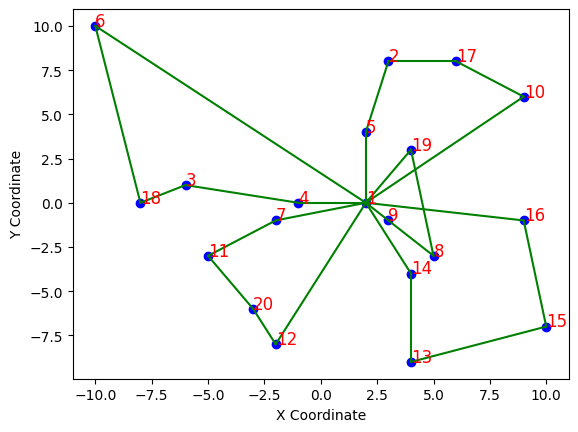

In [7]:
# Split delivery VRP (SVRP)

# Problem initialization
SVRP = pulp.LpProblem("Vehicle_Routing_Problem", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("x", [(i, j) for i in nodes for j in nodes if i != j], lowBound=0, upBound=2, cat='Integer')  # Route selection
y = pulp.LpVariable.dicts("y", [(i, j) for i in nodes for j in nodes if i != j], lowBound=0, upBound=vCap, cat='Continuous')  # Load

# Objective function
SVRP += pulp.lpSum(distances[(i, j)] * x[(i, j)] for i in nodes for j in nodes if i != j), "Total Distance Traveled"

# Constraints
# At most vNum vehicles can depart the depot
SVRP += pulp.lpSum(x[(1, j)] for j in nodes if j != 1) <= vNum, "MaxVehiclesFromDepot"

# vehicle conservation
for j in nodes:
        SVRP += pulp.lpSum(x[(i, j)] for i in nodes if i != j) == pulp.lpSum(x[(j, i)] for i in nodes if i != j), f"VConserveNode_{j}"

# Each customer node visited exactly once
for j in nodes:
    if j != 1:  # Excluding depot
        SVRP += pulp.lpSum(x[(i, j)] for i in nodes if i != j) >= 1, f"EnterNode_{j}"
        SVRP += pulp.lpSum(x[(j, i)] for i in nodes if i != j) >= 1, f"ExitNode_{j}"

# Vehicle capacity usage
for i in nodes:
    for j in nodes:
            if i != j:
                SVRP += y[(i, j)] <= vCap * x[(i, j)], f"CapacityUsage_{(i,j)}"

# Flow conservation and vehicle capacity usage
for j in nodes:
    if j != 1:  # Excluding depot
        SVRP += pulp.lpSum(y[(i, j)] for i in nodes if i != j) - pulp.lpSum(y[(j, k)] for k in nodes if k != j) == nodes[j]['demand'], f"DemandSatisfied_{j}"

# Solve the problem
SVRP.solve(pulp.GUROBI_CMD())

# Output the results
print(f"Vehicle travels:")
for i, j in product(nodes, nodes):
    if i != j and pulp.value(x[(i, j)]) == 1:
        print(f" from {i} to {j}; flow = {pulp.value(y[(i, j)])}")


print(f"Total Distance Traveled (Objective Value): {pulp.value(SVRP.objective)}")

# Extract the solution
routes = [(i, j) for i in nodes for j in nodes if i != j and pulp.value(x[(i, j)]) >= 1]

# Draw the network

for node in nodes:
    plt.scatter(*nodes[node]['coords'], color='blue')
    plt.text(*nodes[node]['coords'], str(node), color='red', fontsize=12)

# Draw the routes
for i, j in routes:
    plt.plot([nodes[i]['coords'][0], nodes[j]['coords'][0]], [nodes[i]['coords'][1], nodes[j]['coords'][1]], color='green')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
#plt.title('VRP Solution')p
#plt.savefig('VRP_Sol.png', dpi=300)
plt.show()

In [6]:
pulp.pulpTestAll()

s

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssc:\Users\laj11\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\apis\gurobi_api.py:443: UserWarning: GUROBI error: Set parameter LogFile to value "gurobi.log"

Failed to set up a license

Error 10009: No Gurobi license found (user laj11, host LUKE-JONES-LAPT, hostid 263c9044, cores 6)


.
  warnings.warn(f"GUROBI error: {out}.")
sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

	 Testing 'indexs' param continues to work for LpVariable.dicts
	 Testing 'indexs' param continues to work for LpVariable.matrix
	 Testing 'indices' argument works in LpVariable.dicts
	 Testing 'indices' param continues to work for LpVariable.matrix
	 Testing invalid status
	 Testing continuous LP solution - export dict
	 Testing export dict for LP
	 Testing export dict MIP
	 Testing maximize continuous LP solution
	 Testing continuous LP solution - export JSON
	 Testing continuous LP solution - export solver dict
	 Testing continuous LP solution - export solver JSON


..........s........

	 Testing reading MPS files - binary variable, no constraint names
	 Testing reading MPS files - integer variable
	 Testing reading MPS files - maximize
	 Testing reading MPS files - noname
	 Testing invalid var names
	 Testing logPath argument
	 Testing makeDict general behavior
	 Testing makeDict default value behavior
	 Testing options parsing
	 Testing that `readsol` can parse CPLEX mipopt solution
	 Testing the availability of the function pulpTestAll
	 Testing zero subtraction
	 Testing inconsistent lp solution
	 Testing continuous LP solution
	 Testing maximize continuous LP solution


........

	 Testing unbounded continuous LP solution
	 Testing Long Names
	 Testing repeated Names
	 Testing zero constraint
	 Testing zero objective
	 Testing LpVariable (not LpAffineExpression) objective
	 Testing Long lines in LP
	 Testing LpAffineExpression divide


........

	 Testing MIP solution
	 Testing MIP solution with floats in objective
	 Testing Initial value in MIP solution
	 Testing fixing value in MIP solution
	 Testing MIP relaxation
	 Testing feasibility problem (no objective)
	 Testing an infeasible problem
	 Testing an integer infeasible problem


.........

	 Testing another integer infeasible problem
	 Testing column based modelling
	 Testing dual variables and slacks reporting
	 Testing fractional constraints
	 Testing elastic constraints (no change)
	 Testing elastic constraints (freebound)


...s..sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

	 Testing elastic constraints (penalty unchanged)
	 Testing elastic constraints (penalty unbounded)
	 Testing timeLimit argument


sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
----------------------------------------------------------------------
Ran 1285 tests in 10.495s

OK (skipped=1226)
